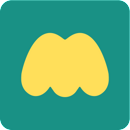

# Modak - data engineer challenge

## 1. Imports

functions and variables were defined in the `utils` folder 

In [1]:
from utils.load_n_transform import (
    get_allowance_backend_table, 
    get_payment_schedule_backend_table, 
    get_allowance_events
)

from utils.payment_schedule import (
    get_events_logs,
    update_allowance_backend_table, 
    generate_payment_schedule_backend_table
)

from utils.plot import (
    top_n_payment_dates_plot,
    top_n_allowances_plot,
    plot_categorical_variables,
    plot_contingency_table,
    plot_frequency_and_errors
)

import pandas as pd

## 2. Data

in this part all the data was transformed into `pd.DataFrame` for easy development and analytics. for prod environments other solutions are encouraged for improvement of performance.

In [2]:
allowance_backend_table = get_allowance_backend_table()
allowance_backend_table.head()

/Users/rafaelkovashikawa/Downloads/projects/demdk/utils/load_n_transform.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.to_datetime(val, unit='s')


,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
1973,7cbedb99-a6d4-45a1-880d-0e661d4b9f75,2024-07-25 18:18:14,biweekly,saturday,2024-11-21 15:25:27.689063932+00:00,30,enabled
1974,c5a7c5f7-6c1e-4ea0-919a-f7efdf4e7cc9,2024-07-25 18:19:09,weekly,friday,2024-08-11 15:29:58.864236548+00:00,16,disabled
1326,c440479e-8cf2-402e-8da9-9c682ea3df39,2024-07-25 18:25:46,biweekly,thursday,2024-11-28 08:00:33.049761141+00:00,12,enabled
798,27602664-335c-4beb-9dd7-7c6942385b64,2024-07-25 18:26:29,weekly,friday,2024-07-26 17:22:16.495657547+00:00,26,disabled
800,d278205f-4175-4dbb-a398-5661a0a9c9f3,2024-07-25 18:26:41,weekly,sunday,2024-12-01 08:01:44.700817530+00:00,8,enabled


In [3]:
payment_schedule_backend_table = get_payment_schedule_backend_table()
payment_schedule_backend_table.head()

,uuid,payment_date
0,061d8039-b332-40ca-b906-3514b06411c2,22
1,0ca92d01-feed-42e5-b90c-299b615f9d3f,22
2,160bcd2d-3ab0-4a60-9bfa-ccfcc1ee17e4,22
3,1649fee7-c424-4fb7-ac84-db36e15e042a,22
4,1d647703-874d-4744-b4de-6a5212518aa8,22


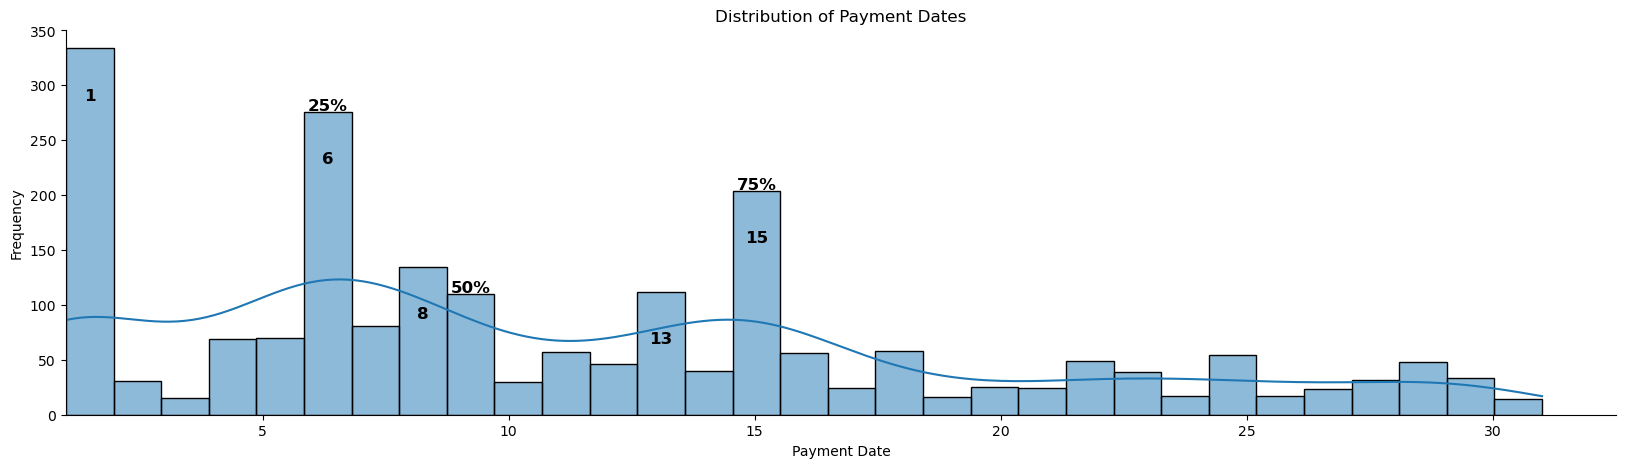

In [4]:
top_n_payment_dates_plot(payment_schedule_backend_table)

In [5]:
allowance_events = get_allowance_events()
allowance_events.head()

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
0,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-21 01:39:34,allowance.created,weekly,sunday,10
1,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
2,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
3,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 06:32:28,allowance.created,biweekly,friday,10
4,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 06:32:37,allowance.edited,weekly,friday,10


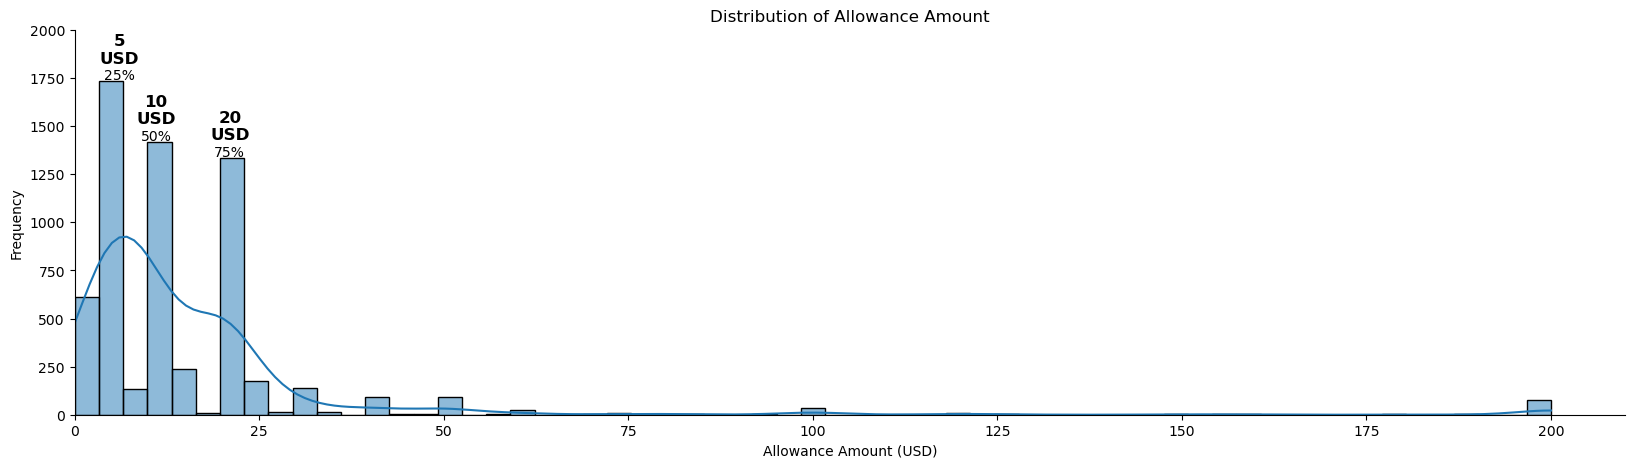

In [6]:
top_n_allowances_plot(allowance_events, top_n=3)

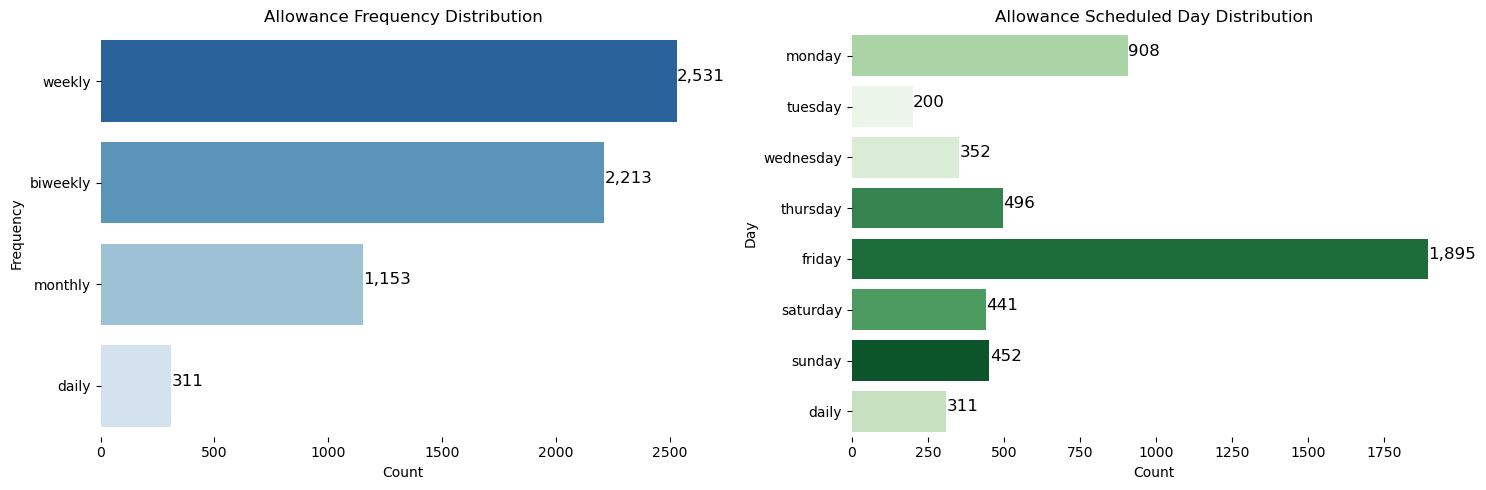

In [7]:
plot_categorical_variables(allowance_events)

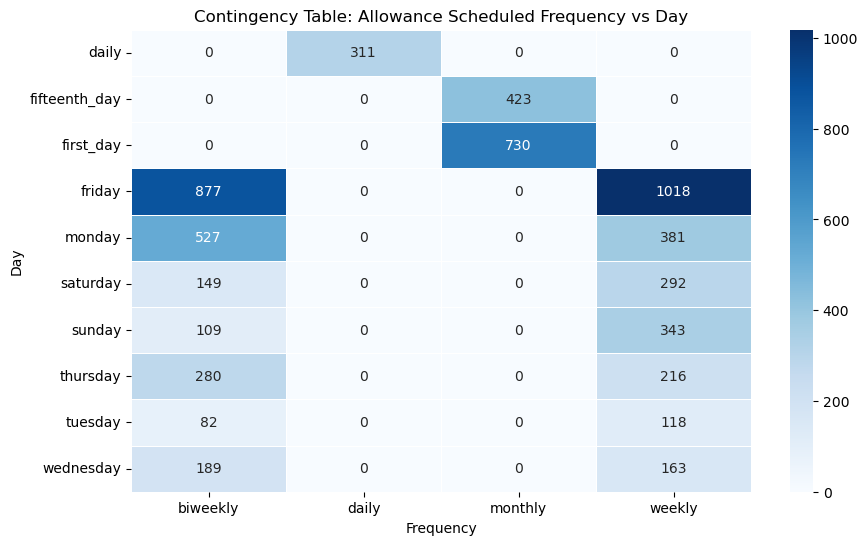

In [8]:
plot_contingency_table(allowance_events)

## 3. Solutions

the goal in this exercise is to correct the payment schedules at `allowance_backend_table` and `payment_schedule_backend_table` through the `allowance_events` logs.

afterwards, compare the errors and infer patterns.

the `events_df` are the logs from `allowance_events.json`

In [9]:
events_df = allowance_events.copy()

the `allowance_backend_df` is the generated table based on the `allowance_events` logs and the original `allowance_backend_table`, the goal here is to use the most of the logs and only keep the `status` field as source of truth in this table, as we will see below.

`biweekly` -> assumed it's paid in the 1st and 3rd weeks only, the revealed preference of clients show that over 75% of them rather pay between these weeks

In [10]:
events_df = allowance_events.copy()

# generate allowance backend results using normalize_scheduled_day and get_next_payment_date
allowance_backend_df = update_allowance_backend_table(allowance_backend_table, events_df)

# checking the differences with detailed comparison
check_field_df = allowance_backend_table.merge(allowance_backend_df, on='uuid', suffixes=('_og', '_updated'))
check_field_df = check_field_df[check_field_df['status_og'] == 'enabled']

# these columns were not changed at all or do not have any relevant information for the comparison
check_field_df.drop(columns=['creation_date_og', 'updated_at_og', 'creation_date_updated', 'updated_at_updated', 'status_og', 'status_updated'], inplace=True)

#### `frequency` and `day` field check

for uuid `'308b2b9c-d49d-4b2d-947c-5b2370da090f'` there is no record of frequency_og, day_og to be as they were in the backend table. there's an issue here.

In [11]:
check_field_df[(check_field_df['frequency_og'] != check_field_df['frequency_updated']) 
               & (check_field_df['day_og'] != check_field_df['day_updated'])]

,uuid,frequency_og,day_og,next_payment_day_og,frequency_updated,day_updated,next_payment_day_updated
630,308b2b9c-d49d-4b2d-947c-5b2370da090f,monthly,first_day,1,weekly,sunday,8.0


In [12]:
get_events_logs(events_df, '308b2b9c-d49d-4b2d-947c-5b2370da090f')

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
1713,308b2b9c-d49d-4b2d-947c-5b2370da090f,2024-09-09 14:31:44,allowance.created,weekly,sunday,2


#### `next_payment` field check

the logic is precise and the code works, for any sample manually tested so far

In [13]:
check_field_df[check_field_df['next_payment_day_og'] != check_field_df['next_payment_day_updated']].sample(5)

,uuid,frequency_og,day_og,next_payment_day_og,frequency_updated,day_updated,next_payment_day_updated
2814,32d50adf-c09f-41a6-aac8-b234c9b21900,weekly,sunday,1,weekly,sunday,8.0
1549,96fd4bcc-58be-4163-9cf1-d2e58490a457,biweekly,friday,25,biweekly,friday,6.0
112,499609fd-fc75-491f-99ec-1423734a842d,weekly,thursday,14,weekly,thursday,5.0
1130,1d647703-874d-4744-b4de-6a5212518aa8,biweekly,friday,22,biweekly,friday,6.0
2346,9b5a1bfb-29c6-49b4-bcab-fa3596f356c2,weekly,friday,22,weekly,friday,6.0


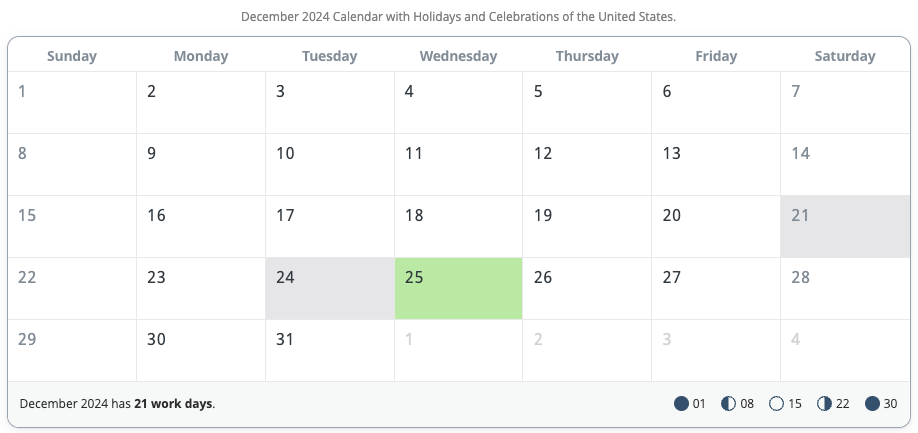

In [14]:
allowance_backend_df[['frequency', 'day']].drop_duplicates().reset_index(drop=True).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
frequency,biweekly,weekly,biweekly,weekly,biweekly,monthly,biweekly,monthly,biweekly,weekly,biweekly,weekly,weekly,weekly,weekly,biweekly,daily
day,saturday,friday,thursday,sunday,friday,first_day,monday,fifteenth_day,tuesday,thursday,wednesday,wednesday,monday,tuesday,saturday,sunday,daily


* errors in the `daily` frequency are mostly because the table was not updated on the `CURRENT_DATE`
* `biweekly` concentrated most of the errors, followed by the `biweekly`
* single `monthly` is caused by similar issue on the relations of events logs, as we can see below

/Users/rafaelkovashikawa/Downloads/projects/demdk/utils/plot.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/Users/rafaelkovashikawa/Downloads/projects/demdk/utils/plot.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


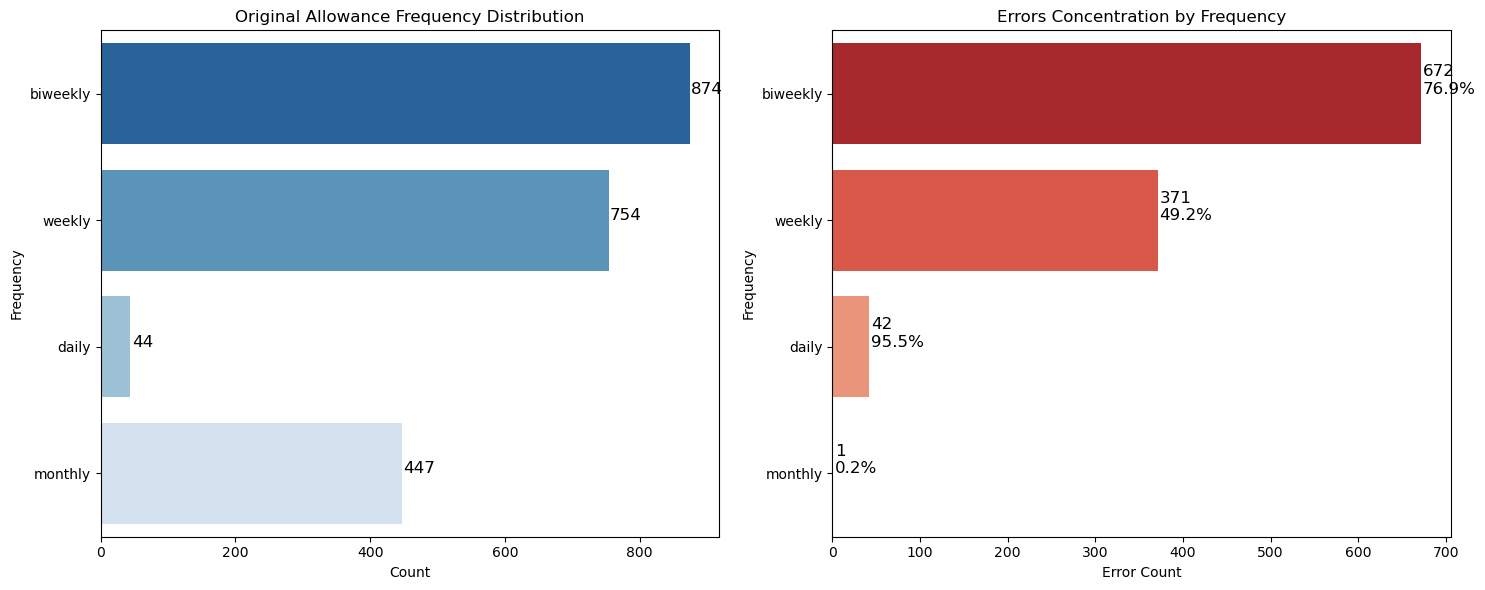

In [19]:
plot_frequency_and_errors(check_field_df)

In [17]:
error_df = check_field_df[check_field_df['next_payment_day_og'] != check_field_df['next_payment_day_updated']]
error_df[error_df['frequency_og'] == 'monthly']


,uuid,frequency_og,day_og,next_payment_day_og,frequency_updated,day_updated,next_payment_day_updated
630,308b2b9c-d49d-4b2d-947c-5b2370da090f,monthly,first_day,1,weekly,sunday,8.0


In [26]:
get_events_logs(events_df, '308b2b9c-d49d-4b2d-947c-5b2370da090f')

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
1713,308b2b9c-d49d-4b2d-947c-5b2370da090f,2024-09-09 14:31:44,allowance.created,weekly,sunday,2


### finally, the `payment_schedule_backend_table` check

the solution of this table is based on the same logic, but with fewer steps as it was solved for the `allowance_backend_table`.

the problem relies on the `payment_date` that is reflected on the former table, therefore should be equal.

In [20]:
payment_schedule_df = generate_payment_schedule_backend_table(allowance_backend_df)

**suggestion**: this plot would be great to be added to a grafana dashboard and also one similar with the volume of allowances, so it can be tracked in real time the distribution of payments

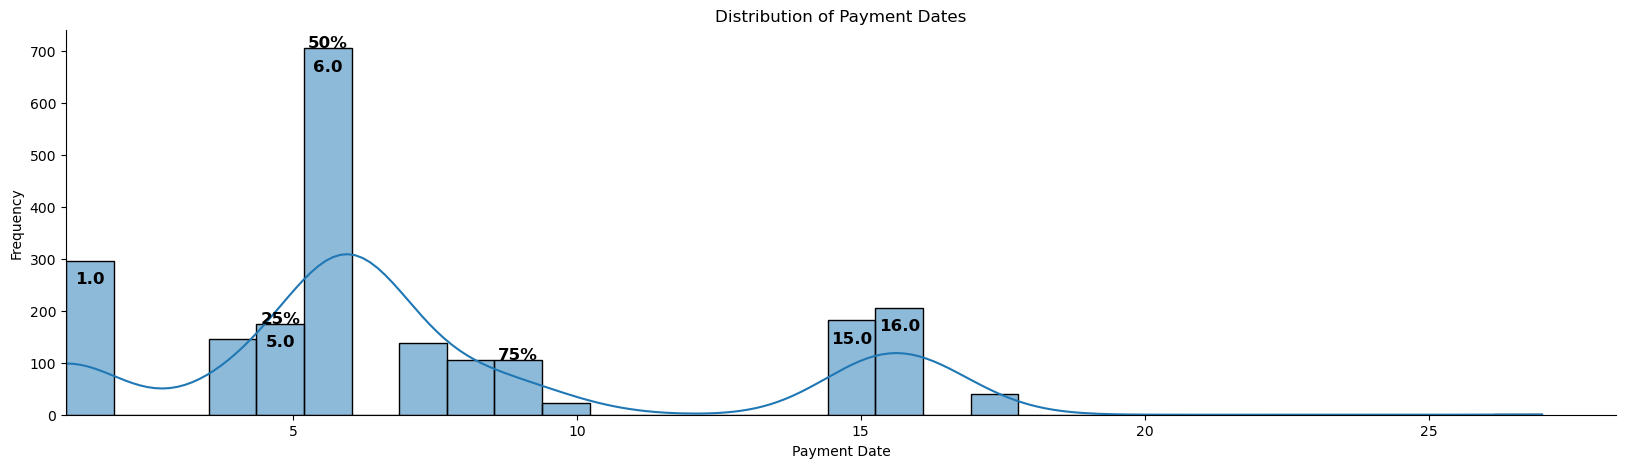

In [21]:
top_n_payment_dates_plot(payment_schedule_df)

In [22]:
payment_schedule_df

,uuid,payment_date
0,7cbedb99-a6d4-45a1-880d-0e661d4b9f75,7.0
1,c440479e-8cf2-402e-8da9-9c682ea3df39,5.0
2,d278205f-4175-4dbb-a398-5661a0a9c9f3,8.0
3,17df1db7-0a6a-4661-90d6-949b601ab02b,16.0
4,fb835932-ac1e-45a7-8706-545805841d0c,6.0
...,...,...
2114,2a18265a-128b-446e-aba2-045e38bd66bc,15.0
2115,397f8b21-3af1-4a08-81eb-e085eb1160ca,6.0
2116,1fc74dc2-7d96-4a2a-a8c0-ae3a61eacf7d,6.0
2117,60d0d14e-33e6-45ae-b7f3-c5c1d732f734,15.0


we can see that the original tables do not reflect the same data for the fields `next_payment_day` and `payment_date`, also it should not store records for disabled allowances.

In [23]:
check_payment_days = payment_schedule_backend_table.merge(allowance_backend_table, on='uuid')
check_payment_days[check_payment_days['payment_date'] != check_payment_days['next_payment_day']].head()

,uuid,payment_date,creation_date,frequency,day,updated_at,next_payment_day,status
38,de5adfec-76eb-4b37-a758-cedd31e55028,22,2024-11-13 20:54:35,biweekly,friday,2024-11-23 14:57:11.423569641+00:00,6,enabled
40,e359dbab-86cf-4576-8d16-3c08df3f6a41,22,2024-11-16 18:32:45,daily,daily,2024-11-26 20:14:36.448853388+00:00,24,disabled
95,d299d804-0d05-48c8-ad62-601d54438e34,18,2024-08-01 00:51:04,weekly,sunday,2024-10-22 16:57:32.942176553+00:00,27,enabled
96,d50f10fd-d41a-469c-a5ec-8effe16c79bb,18,2024-10-16 03:39:35,weekly,friday,2024-10-24 00:39:51.646961101+00:00,25,enabled
145,93ccc2bd-bacc-4286-8f9b-1281af567fa9,16,2024-10-26 05:40:52,daily,daily,2024-11-19 22:57:30.829279411+00:00,20,enabled


we can see that they have a many inconsistencies

In [24]:
# checking the differences with detailed comparison
check_schedule_df = payment_schedule_backend_table.merge(payment_schedule_df, how='left', on='uuid', suffixes=('_og', '_updated'))

print('number of errors:', check_schedule_df[check_schedule_df['payment_date_og'] != check_schedule_df['payment_date_updated']].size)
print('sample of errors:')

check_schedule_df[check_schedule_df['payment_date_og'] != check_schedule_df['payment_date_updated']].sample(5)

number of errors: 3318
sample of errors:


,uuid,payment_date_og,payment_date_updated
1833,d57bb471-2a53-4dcc-9bcf-4038806e26aa,12,7.0
1652,42f61042-3d31-42ff-9f1a-508716069464,20,4.0
1355,13acc700-18d1-4e4b-9922-0a7855466c70,4,6.0
1219,69c3aee7-edb5-4914-9037-486a2e03ae2c,30,7.0
342,5805dff1-bc9c-4e20-b4dd-55248c8ffe8a,8,6.0
